In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

In [2]:
def get_y_fn(fn): return fn.with_suffix(fn.suffix+'.cat')
def get_kpts(fn): return np.genfromtxt(fn)[1:].reshape(-1,2)
def get_y(fn):    return get_kpts(get_y_fn(fn))

In [3]:
source = Path('/home/lgvaz/.data/cats')
mpath  = Path('models/stage2-512')

In [4]:
learn = torch.load(mpath)

In [5]:
class CatPoint(TensorPoint):
  @property
  def leye(self): return self[0]
  @property
  def reye(self): return self[1]
  @property
  def mouth(self): return self[2]
  @property
  def lear(self): return self[3:6]
  @property
  def rear(self): return self[6:9]
  
  # this fails if you dont override
  @classmethod
  def create(cls, t, img_size=None)->None:
    "Convert an array or a list of points `t` to a `Tensor`"
    return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

In [7]:
def get_head_pnts(pt):
  left,top = pt.lear.min(axis=0)[0].numpy()
  right,_  = pt.rear.max(axis=0)[0].numpy()
  bottom = min(pt.leye[1], pt.reye[1])
  pnts = np.array([left,top,right,bottom], dtype=int)
  return pnts

In [8]:
def get_angle(pt):
  x,y = pt.rear[-1] - pt.lear[0] 
  slope = np.divide(y,x, where=x!=0)
  return -np.arctan(slope) * (180/np.pi)

In [9]:
def get_size(pnts):
  return pnts[2:]-pnts[:2]

In [10]:
def predict(learn, item, rm_type_tfms=None, with_input=False):
    dl = learn.dls.test_dl([item], rm_type_tfms=rm_type_tfms)
    inp,preds,_,dec_preds = learn.get_preds(dl=dl, with_input=True, with_decoded=True)
    i = getattr(learn.dls, 'n_inp', -1) - 1
    dec_inp, full_dec = map(detuplify, learn.dls.decode_batch((*tuplify(inp),*tuplify(dec_preds)))[0][i:])
    res = full_dec,dec_preds[0],preds[0]
    if with_input: res = (dec_inp,) + res
    return res

In [11]:
def unscale_pnts(y, sz): return CatPoint((y+1) * tensor(sz).float()/2, img_size=sz)

In [12]:
hat = PILImage.create('hats/hat1.png', mode='RGBA')
def get_hat_pt(pt):
  angle = get_angle(pt)
  head = get_head_pnts(pt)
  w,_ = get_size(head)
  # Substitute top of head to maintain hat ratio
  h = w/np.divide(*hat.size)
  head[1] = head[-1] - h
  return head

In [13]:
def put_hat(im, cat_pt, hat_pt, hat):
  im = im.copy()
  hat = hat.resize(get_size(hat_pt)).rotate(get_angle(cat_pt))
  im.paste(hat, hat_pt, hat)
  return im

In [14]:
fn = 'cats/cat4.jpeg'
# fn = fns[42]
im = PILImage.create(fn)
_,_,pred = predict(learn, fn)

In [15]:
cat_pt = unscale_pnts(pred.reshape(-1, 2), im.size)
hat_pt = get_hat_pt(cat_pt)

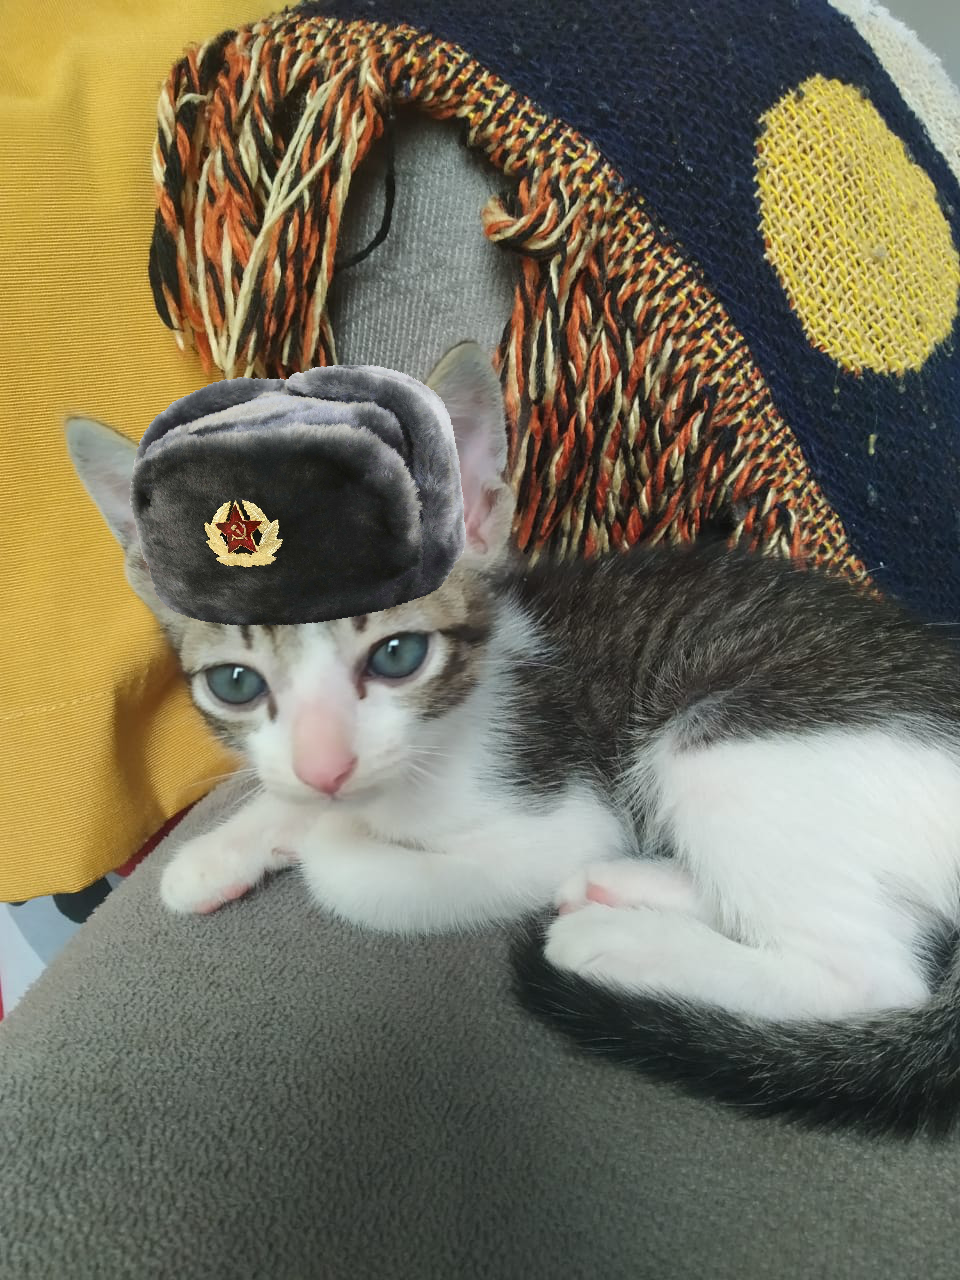

In [16]:
im = put_hat(im, cat_pt, hat_pt, hat)
im